In [4]:
import numpy as np
from scipy.stats import expon, truncexpon, uniform


# Based on Mondrian Forests: Efficient Online Random Forests
# https://arxiv.org/pdf/1406.2673.pdf


GAMMA = 20

from mondrianforest import MondrianTree

# def data_ranges(data):
#     return np.min(data, axis=0), np.max(data, axis=0)


# class MondrianTree:
#     def __init__(self, budget=np.inf, random_state=None):  # TODO: use random state
#         self.leaf_nodes = set()
#         self.budget = budget
#         self.classes = None
#         self.class_indices = None
#         self.root = None
#         self.X = None
#         self.y = None
#         self.fitted = False

#     # Algorithm 1 + fully online option
#     def fit(self, X, y, online=False):
#         self.X = X
#         self.y = y
#         self.classes = np.unique(y)
#         self.class_indices = {cls: i for i, cls in enumerate(self.classes)}
#         if not online:
#             self.root = MondrianBlock(X, y, parent=None, budget=self.budget, tree=self)
#             self.compute_predictive_posterior()
#         else:
#             self.root = MondrianBlock(X[:2], y[:2], parent=None, budget=self.budget, tree=self)
#             for i in range(2, len(y)):
#                 self.extend(X[i], y[i])
#                 plot_2d_mondrian_tree(self, X, y)
#             self.compute_predictive_posterior()

#         self.fitted = True

#     # Algorithm 7
#     def compute_predictive_posterior(self):
#         queue = [self.root]
#         while queue:
#             node = queue.pop()
#             if node.parent is None:
#                 parent_posterior = np.ones_like(self.classes) / len(self.classes)  # H
#             else:
#                 parent_posterior = node.parent.posterior_predictive

#             class_counts = node.class_counts
#             tables = node.tables
#             discount = node.discount

#             node.posterior_predictive = (class_counts - discount * tables
#                                          + discount * np.sum(tables) * parent_posterior) / np.sum(class_counts)

#             if node.left:
#                 queue = [node.left] + queue
#             if node.right:
#                 queue = [node.right] + queue

#     # Algorithm 8
#     def predict(self, x):
#         assert len(x.shape) == 1  # prediction for single x for now

#         x += 1e-12  # dirty hack in case x is included in the training

#         current = self.root
#         pnsy = 1.
#         s = np.zeros_like(self.classes, dtype=np.float64)
#         while True:
#             cost_difference = current.cost - current._parent_cost()
#             eta = (np.maximum(x - current.upper, 0) + np.maximum(current.lower - x, 0)).sum()
#             psjx = -np.expm1(-eta * cost_difference)
#             if psjx > 0:
#                 expected_discount = (eta / (eta + GAMMA)) * (-np.expm1(-(eta + GAMMA) * cost_difference)) \
#                            / (-np.expm1(-eta * cost_difference))

#                 class_counts = tables = np.minimum(current.class_counts, 1)

#                 if current.parent is None:
#                     tilde_parent_posterior = np.ones_like(self.classes) / len(self.classes)
#                 else:
#                     tilde_parent_posterior = current.parent.posterior_predictive

#                 posterior = (class_counts / np.sum(class_counts) - expected_discount * tables
#                              + expected_discount * tables.sum() * tilde_parent_posterior)
#                 s += pnsy * psjx * posterior
#             if current.is_leaf:
#                 s += pnsy * (1 - psjx) * current.posterior_predictive
#                 return s
#             else:
#                 pnsy *= 1 - psjx
#                 if x[current.delta] <= current.xi:
#                     current = current.left
#                 else:
#                     current = current.right

#     def extend(self, X, y):
#         self.root.extend(X, y)


# class MondrianBlock:
#     def __init__(self, X, y, budget, parent=None, tree: MondrianTree = None, fit=True):
#         assert tree
#         self.tree = tree
#         self.parent = parent
#         self.left = None
#         self.right = None
#         self.budget = budget
#         self.discount = 0
#         self.lower = np.zeros(X.shape[1]) if X is not None else None
#         self.upper = np.zeros_like(self.lower) if X is not None else None
#         self.sides = np.zeros_like(self.lower) if X is not None else None
#         self.class_counts = np.zeros_like(self.tree.classes)  # not exactly _counts_
#         self.tables = np.zeros_like(self.tree.classes)  # see Chinese restaurants notation in the paper
#         self.is_leaf = True  # will be set to False when needed

#         if fit:
#             self._fit(X, y)

#     def _parent_cost(self):
#         if self.parent is None:
#             return 0.
#         else:
#             return self.parent.cost

#     # Algorithm 5
#     def _initialize_posterior_counts(self, X, y):
#         for i, cls in enumerate(self.tree.classes):
#             self.class_counts[i] = np.count_nonzero(y == cls)
#         current = self
#         while True:
#             if not current.is_leaf:
#                 l_tables = current.left.tables if current.left else np.zeros_like(current.class_counts)
#                 r_tables = current.right.tables if current.right else np.zeros_like(current.class_counts)
#                 current.class_counts = l_tables + r_tables
#             current.tables = np.minimum(current.class_counts, 1)
#             if current.parent is None:
#                 break
#             else:
#                 current = current.parent

#     # Algorithm 6
#     def _update_posterior_counts(self, y):
#         class_index = self.tree.class_indices[y]
#         self.class_counts[class_index] += 1
#         current = self
#         while True:
#             if current.tables[class_index] == 1:
#                 return
#             else:
#                 if not current.is_leaf:
#                     l_table = current.left.tables[class_index] if current.left else 0
#                     r_table = current.right.tables[class_index] if current.right else 0
#                     current.class_counts[class_index] = l_table + r_table
#                 current.tables[class_index] = np.minimum(current.class_counts[class_index], 1)
#                 if current.parent is None:
#                     return
#                 else:
#                     current = current.parent

#     # Algorithm 9
#     def _fit(self, X, y):
#         self.lower, self.upper = data_ranges(X)
#         self.sides = self.upper - self.lower

#         if len(y) <= 0 or np.all(y == y[0]):  # all labels identical
#             self.cost = self.budget
#         else:
#             split_cost = expon.rvs(scale=(1 / self.sides.sum()))
#             self.cost = self._parent_cost() + split_cost

#         if self.cost < self.budget:
#             # choose split dimension delta and location xi
#             self.delta = np.random.choice(np.arange(X.shape[1]), p=(self.sides / self.sides.sum()))
#             self.xi = uniform.rvs(loc=self.lower[self.delta], scale=self.sides[self.delta])

#             # perform an actual split
#             left_indices = X[:, self.delta] <= self.xi
#             X_left, y_left = X[left_indices], y[left_indices]
#             X_right, y_right = X[~left_indices], y[~left_indices]

#             # sample children
#             self.is_leaf = False
#             # we first create unfitted blocks and then fit because otherwise self.left and self.right
#             # may be accessed in ._initialize_posterior_counts before being assigned
#             self.left = MondrianBlock(X_left, y_left, budget=self.budget, parent=self, tree=self.tree, fit=False)
#             self.left._fit(X_left, y_left)
#             self.right = MondrianBlock(X_right, y_right, budget=self.budget, parent=self, tree=self.tree, fit=False)
#             self.right._fit(X_right, y_right)
#         else:
#             self.cost = self.budget
#             self.tree.leaf_nodes.add(self)
#             self._initialize_posterior_counts(X, y)

#         self.discount = np.exp(-GAMMA * (self.cost - self._parent_cost()))

#     def _get_subset_indices(self):
#         return np.all(self.tree.X >= self.lower, axis=1) & np.all(self.tree.X <= self.upper, axis=1)

#     def _get_label_subset(self, indices=None):
#         if indices is None:
#             indices = self._get_subset_indices()
#         return self.tree.y[indices]

#     def _get_feature_subset(self, indices=None):
#         if indices is None:
#             indices = self._get_subset_indices()
#         return self.tree.X[indices]

#     def _get_feature_label_subset(self, indices=None):
#         if indices is None:
#             indices = self._get_subset_indices()
#         return self._get_feature_subset(indices), self._get_label_subset(indices)

#     # Algorithm 10
#     def extend(self, x, y):
#         labels = self._get_label_subset()
#         if len(labels) <= 0 or np.all(labels == labels[0]):  # all labels identical
#             self.lower = np.minimum(self.lower, x)
#             self.upper = np.maximum(self.upper, x)
#             self.tree.X = np.vstack((self.tree.X, x))  # TODO: we possibly don't have to
#             self.tree.y = np.hstack((self.tree.y, y))
#             if y == labels[0]:
#                 self._update_posterior_counts(y)
#                 return
#             else:
#                 self.tree.leaf_nodes.remove(self)
#                 X, y = self._get_feature_label_subset()
#                 self._fit(X, y)
#         else:
#             el = np.maximum(self.lower - x, 0)
#             eu = np.maximum(x - self.upper, 0)
#             sum_e = el + eu

#             split_cost = expon.rvs(scale=(1 / sum_e.sum()))
#             if self._parent_cost() + split_cost < self.cost:
#                 delta = np.random.choice(np.arange(len(x)), p=(sum_e / sum_e.sum()))
#                 if x[delta] > self.upper[delta]:
#                     xi = uniform.rvs(loc=self.upper[delta], scale=x[delta] - self.upper[delta])
#                 else:
#                     xi = uniform.rvs(loc=x[delta], scale=self.lower[delta] - x[delta])

#                 j_tilde = MondrianBlock(None, None, budget=self.budget, parent=self.parent, tree=self.tree, fit=False)
#                 j_tilde_attrs = {
#                     'delta': delta,
#                     'xi': xi,
#                     'cost': self._parent_cost() + split_cost,
#                     'lower': np.minimum(self.lower, x),
#                     'upper': np.maximum(self.upper, x),
#                     'sides': np.maximum(self.upper, x) - np.minimum(self.lower, x),
#                     'is_leaf': False,
#                 }
#                 for attr, value in j_tilde_attrs.items():
#                     setattr(j_tilde, attr, value)

#                 if self.parent is None:
#                     self.tree.root = j_tilde
#                     print(x, 'changing root')
#                 else:
#                     if self is self.parent.left:
#                         self.parent.left = j_tilde
#                     elif self is self.parent.right:
#                         self.parent.right = j_tilde

#                 j_primes = MondrianBlock(X=np.array([x]), y=np.array([y]), budget=self.budget,
#                                          parent=j_tilde, tree=self.tree)
#                 if x[delta] > xi:
#                     j_tilde.left = self
#                     j_tilde.right = j_primes
#                 else:
#                     j_tilde.left = j_primes
#                     j_tilde.right = self
#             else:
#                 self.lower = np.minimum(self.lower, x)
#                 self.upper = np.maximum(self.upper, x)
#                 if not self.is_leaf:
#                     if x[self.delta] <= self.xi:
#                         child = self.left
#                     else:
#                         child = self.right
#                     child.extend(x, y)


# class MondrianRandomForest:
#     def __init__(self, n_estimators=100, budget=np.inf, random_state=4):
#         self.n_estimators = n_estimators
#         self.estimators = []
#         self.budget = budget
#         self.random_state = random_state

#     def fit(self, X, y, online=False):
#         if not online:
#             for i in range(self.n_estimators):
#                 self.estimators.append(MondrianTree(self.budget))
#                 self.estimators[-1].fit(X, y, online=False)

#     def predict(self, x):
#         assert len(x.shape) == 1

#         predictions = np.zeros((self.n_estimators, len(self.estimators[0].classes)))
#         return predictions.mean(axis=0)


In [5]:
def plot_2d_mondrian_block(block):
        plt.hlines([block.lower[1], block.upper[1]], 
                   block.lower[0], block.upper[0], 
                   linestyles='dashed', alpha=0.3)
        plt.vlines([block.lower[0], block.upper[0]], 
                   block.lower[1], block.upper[1], 
                   linestyles='dashed', alpha=0.3)
        if not block.is_leaf:
            if block.delta == 0:
                plt.vlines(block.xi, block.lower[1], block.upper[1], color='red', alpha=0.7)
            elif block.delta == 1:
                plt.hlines(block.xi, block.lower[0], block.upper[0], color='red', alpha=0.7)
        if block.left:
            plot_2d_mondrian_block(block.left)
        if block.right:
            plot_2d_mondrian_block(block.right)

def plot_2d_mondrian_tree(tree, X, y, xlim=None, ylim=None, **kwargs):
    xmin, xmax = (np.min(X[:, 0]), np.max(X[:, 0])) if not xlim else xlim
    xlen = xmax - xmin
    x_margin = 0 if xlim else 0.05 * xlen
    ymin, ymax = (np.min(X[:, 1]), np.max(X[:, 1])) if not ylim else ylim
    ylen = ymax - ymin
    y_margin = 0 if ylim else 0.05 * ylen
    
    plt.figure(**kwargs)
    plt.xlim(xmin - x_margin, xmax + x_margin)
    plt.ylim(ymin - y_margin, ymax + y_margin)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plot_2d_mondrian_block(tree.root)

In [6]:
import warnings
warnings.filterwarnings("error")

In [7]:
np.random.seed(12)
n = 12
n_classes = 2

X = np.random.uniform(size=(n, 2))
y = np.random.randint(0, n_classes, size=n)

m_tree = MondrianTree()
m_tree.fit(X, y, online=True)

labels [0 0]
y 1
labels 0 0
labels [0 0 1 1]
x [0.90071485 0.03342143]
lower [0.01457496 0.53373939]
upper [0.26331502 0.91874701]
el [0.         0.50031797]
eu [0.63739984 0.        ]
[0.90071485 0.03342143] changing root
labels [0 0 1 1 1 0 0 1]
x [0.95694934 0.13720932]
lower [0.01457496 0.03342143]
upper [0.90071485 0.91874701]
el [0. 0.]
eu [0.05623448 0.        ]
labels [1]
y 1
labels 0 1
??
labels [0 0 1 1 1 1 0 0 0 1 1]
x [0.28382835 0.60608318]
lower [0.01457496 0.03342143]
upper [0.95694934 0.91874701]
el [0. 0.]
eu [0. 0.]
labels [0 0 1 1]
x [0.28382835 0.60608318]
lower [0.01457496 0.53373939]
upper [0.26331502 0.91874701]
el [0. 0.]
eu [0.02051334 0.        ]
labels [0 0]
y 1
labels 0 0
labels [0 0 1 1 1 1 0 0 0 1 1 1]
x [0.94422514 0.85273554]
lower [0.01457496 0.03342143]
upper [0.95694934 0.91874701]
el [0. 0.]
eu [0. 0.]
labels [0 0 1 1 1 1]
x [0.94422514 0.85273554]
lower [0.01457496 0.53373939]
upper [0.28382835 0.91874701]
el [0. 0.]
eu [0.66039678 0.        ]
[0.94

RuntimeWarning: invalid value encountered in true_divide

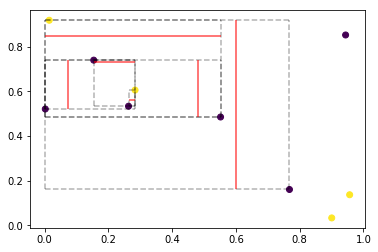

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_2d_mondrian_tree(m_tree, X, y)

In [5]:
m_tree.root.right.lower

array([0.16911084, 0.02075195])

In [6]:
np.argwhere(np.array([0, 0, 1, 0, 0]))

array([[2]])

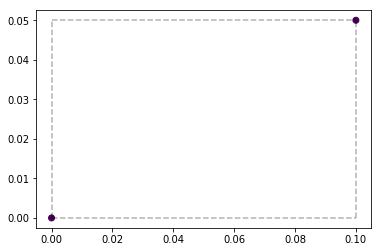

In [7]:
np.random.seed(4)
X = np.array([[0., 0.], [0.1, 0.05], [0.7, 0.7], [2., 0.5]])
y = np.random.randint(0, n_classes, size=4)

m_tree = MondrianTree()
m_tree.fit(X[:2], y[:2], online=False)
plot_2d_mondrian_tree(m_tree, X[:2], y[:2])

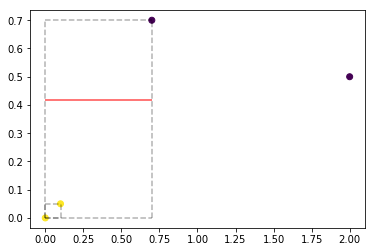

In [8]:
m_tree.extend(X[2], y[2])
plot_2d_mondrian_tree(m_tree, X, y)

[2.  0.5] changing root


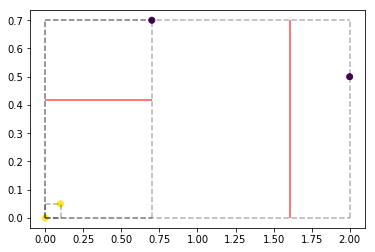

In [9]:
m_tree.extend(X[3], y[3])
plot_2d_mondrian_tree(m_tree, X, y)

In [10]:
m_tree.root.xi

1.607946306682207

In [12]:
m_tree.predict(np.array([0.5, 0.2]))

AttributeError: 'MondrianBlock' object has no attribute 'posterior_predictive'

In [527]:
from sklearn.datasets import load_iris

In [528]:
X, y = load_iris(return_X_y=True)
indices = np.arange(150)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
m_tree = MondrianTree()
m_tree.fit(X[:120], y[:120], online=False)

In [529]:
y

array([2, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2,
       0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 2, 2,
       1, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 1, 0, 0,
       0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 0,
       1, 0, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 0,
       1, 2, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2])

In [530]:
X

array([[5.6, 2.8, 4.9, 2. ],
       [5.7, 2.8, 4.5, 1.3],
       [6.7, 3. , 5. , 1.7],
       [6. , 3. , 4.8, 1.8],
       [7.4, 2.8, 6.1, 1.9],
       [6.8, 3.2, 5.9, 2.3],
       [5.2, 2.7, 3.9, 1.4],
       [6.3, 2.3, 4.4, 1.3],
       [5. , 3.2, 1.2, 0.2],
       [5.8, 2.7, 5.1, 1.9],
       [6.7, 3.1, 4.4, 1.4],
       [5.8, 2.8, 5.1, 2.4],
       [4.8, 3.4, 1.6, 0.2],
       [5. , 3.4, 1.5, 0.2],
       [6.1, 2.9, 4.7, 1.4],
       [4.6, 3.1, 1.5, 0.2],
       [5.2, 3.5, 1.5, 0.2],
       [6.5, 3.2, 5.1, 2. ],
       [4.6, 3.4, 1.4, 0.3],
       [6.2, 3.4, 5.4, 2.3],
       [4.8, 3. , 1.4, 0.1],
       [6.6, 3. , 4.4, 1.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.1, 3.7, 1.5, 0.4],
       [5.1, 3.3, 1.7, 0.5],
       [5.4, 3.4, 1.5, 0.4],
       [5.3, 3.7, 1.5, 0.2],
       [5.4, 3. , 4.5, 1.5],
       [5.8, 2.6, 4. , 1.2],
       [4.8, 3.4, 1.9, 0.2],
       [6.7, 3. , 5.2, 2.3],
       [5.7, 2.5, 5. , 2. ],
       [6.5, 3. , 5.2, 2. ],
       [5. , 2. , 3.5, 1. ],
       [5. , 3

In [535]:
X[121]

array([5.700002, 2.600002, 3.500002, 1.000002])

In [542]:
m_tree.predict(np.array([7., 3., 5.5, 2.]))

/Users/alex/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


array([nan, nan, nan])

In [500]:
m_tree.predict(np.array([0., 0.]))

array([0.47523659, 0.46386972, 0.06089369])

In [364]:
m_tree.predict(np.array([0.03, 0.5]))

array([0.00920882, 0.00920882, 0.98158237])

In [228]:
m_tree.root.class_counts

array([1, 1, 2])